<a href="https://colab.research.google.com/github/park-geun-hyeong/AI_service_from_youtube/blob/main/StockPrice_predict/Naver_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from tqdm import tqdm
import glob

In [23]:
path = '/content/drive/MyDrive/Youtube/stock_price_predict' 

df = pd.read_csv(path+'/naver_predict.csv') 

In [24]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-02-29,116000.0,117000.0,114000.0,114400.0,113343.164063,393545.0
1,2016-03-02,116800.0,122400.0,116200.0,121800.0,120674.804688,595495.0
2,2016-03-03,123000.0,123000.0,120400.0,122000.0,120872.953125,374365.0
3,2016-03-04,123000.0,124200.0,120800.0,122600.0,121467.414063,330580.0
4,2016-03-07,123000.0,123800.0,119800.0,119800.0,118693.281250,379425.0
...,...,...,...,...,...,...,...
1221,2021-02-22,400000.0,405500.0,384500.0,386500.0,386500.000000,1289395.0
1222,2021-02-23,379000.0,394500.0,378500.0,390500.0,390500.000000,1017577.0
1223,2021-02-24,389500.0,391500.0,374000.0,374000.0,374000.000000,1078485.0
1224,2021-02-25,380500.0,384500.0,374500.0,383000.0,383000.000000,757476.0


In [25]:
df=df.fillna(method='pad')
print(df.isna().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [26]:
mid_price = ((df['High']+df['Low'])/2).values
print(mid_price.shape, type(mid_price))

(1226,) <class 'numpy.ndarray'>


## Data Window 처리 (50+1개씩)

In [27]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for idx in range(len(mid_price)- sequence_length):
    result.append(mid_price[idx:idx+sequence_length])


## Data 스케일링

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mm=MinMaxScaler()
st=StandardScaler()

In [29]:
result_mm_scaled = mm.fit_transform(result)
result_st_scaled = st.fit_transform(result)

In [30]:
row = int(round(result_mm_scaled.shape[0]*0.9))
print(row)

1058


##train,test dataset나누기

In [31]:
train1 = result_mm_scaled[:row,:]
train2 = result_st_scaled[:row,:]

test1 = result_mm_scaled[row:,:]
test2 = result_st_scaled[row:,:]

In [32]:
np.random.shuffle(train1)
np.random.shuffle(train2)

In [33]:
x_train1 = train1[:,:-1]
y_train1 = train1[:,-1]
x_test1 = test1[:, :-1]
y_test1 = test1[:, -1]

x_train2 = train2[:,:-1]
y_train2 = train2[:,-1]
x_test2 = test2[:, :-1]
y_test2 = test2[:, -1]

In [34]:
x_train1.shape,y_train1.shape,x_test1.shape,y_test1.shape

((1058, 50), (1058,), (117, 50), (117,))

In [35]:
x_train2.shape,y_train2.shape,x_test2.shape,y_test2.shape

((1058, 50), (1058,), (117, 50), (117,))

In [36]:
x_train1 = np.reshape(x_train1,(x_train1.shape[0],x_train1.shape[1],1))
x_test1 = np.reshape(x_test1,(x_test1.shape[0],x_test1.shape[1],1))
x_train2 = np.reshape(x_train2,(x_train2.shape[0],x_train2.shape[1],1))
x_test2 = np.reshape(x_test2,(x_test2.shape[0],x_test2.shape[1],1))

x_train1.shape, x_test1.shape,x_train2.shape, x_test2.shape

((1058, 50, 1), (117, 50, 1), (1058, 50, 1), (117, 50, 1))

##Model (간단한 LSTM model)

In [37]:
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization
from tensorflow.keras.models import Sequential  
from tensorflow.keras.callbacks import ModelCheckpoint

In [38]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))

model.add(LSTM(64,return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [40]:
model.fit(x_train1, y_train1 ,epochs=20, batch_size=16, verbose=1,validation_data=(x_test1,y_test1))

Epoch 1/20
67/67 [==============================] - 7s 49ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 2/20
67/67 [==============================] - 3s 40ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 3/20
67/67 [==============================] - 3s 40ms/step - loss: 8.5681e-04 - val_loss: 0.0049
Epoch 4/20
67/67 [==============================] - 3s 40ms/step - loss: 9.1030e-04 - val_loss: 0.0057
Epoch 5/20
67/67 [==============================] - 3s 41ms/step - loss: 7.0767e-04 - val_loss: 0.0010
Epoch 6/20
67/67 [==============================] - 3s 40ms/step - loss: 6.3928e-04 - val_loss: 0.0706
Epoch 7/20
67/67 [==============================] - 3s 40ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/20
67/67 [==============================] - 3s 41ms/step - loss: 5.4527e-04 - val_loss: 0.0018
Epoch 9/20
67/67 [==============================] - 3s 41ms/step - loss: 4.2277e-04 - val_loss: 0.0010
Epoch 10/20
67/67 [==============================] - 3s 40ms/step - loss: 3.4328e-04 

In [42]:
pred= model.predict(x_test1)

In [47]:
model2 = Sequential()

model2.add(LSTM(50, return_sequences=True, input_shape=(50,1)))

model2.add(LSTM(64,return_sequences=False))

model2.add(Dense(1, activation='linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [49]:
model.fit(x_train2, y_train2 ,epochs=20, batch_size=16, verbose=1,validation_data=(x_test2,y_test2))

Epoch 1/20
67/67 [==============================] - 7s 52ms/step - loss: 0.0062 - val_loss: 0.0216
Epoch 2/20
67/67 [==============================] - 3s 40ms/step - loss: 0.0036 - val_loss: 0.0186
Epoch 3/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0037 - val_loss: 0.0210
Epoch 4/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0037 - val_loss: 0.0233
Epoch 5/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0035 - val_loss: 0.0382
Epoch 6/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0034 - val_loss: 0.0193
Epoch 7/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0033 - val_loss: 0.0243
Epoch 8/20
67/67 [==============================] - 3s 42ms/step - loss: 0.0029 - val_loss: 0.0822
Epoch 9/20
67/67 [==============================] - 3s 42ms/step - loss: 0.0033 - val_loss: 0.0258
Epoch 10/20
67/67 [==============================] - 3s 41ms/step - loss: 0.0031 - val_loss: 0.1301
Epoch 11/

## 실제 주식값과 인공지능이 예측한 주식값 그래프로 비교해보기

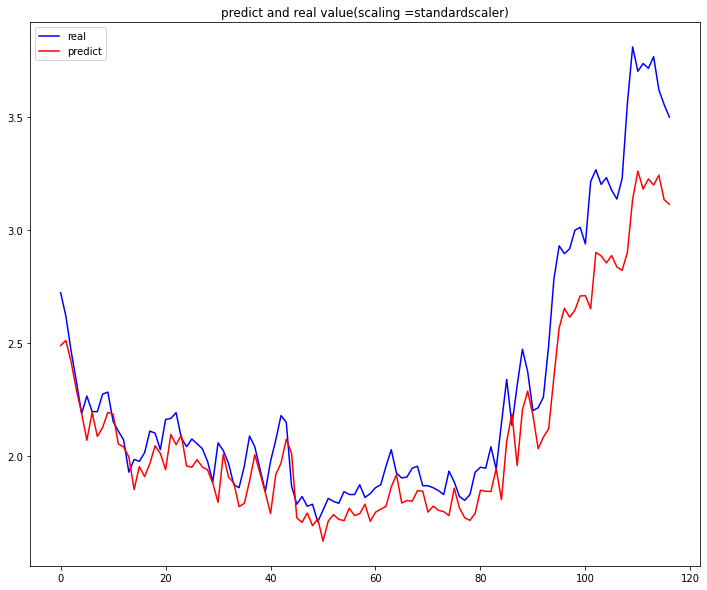

In [50]:
pred2= model.predict(x_test2)

fig,ax=plt.subplots(1,1 ,figsize=(12,10))
ax.plot(y_test2,color='b')
ax.plot(pred2,color='r')
ax.set_title("predict and real value(scaling =standardscaler)")
ax.legend(['real','predict'],loc='upper left')
plt.show()

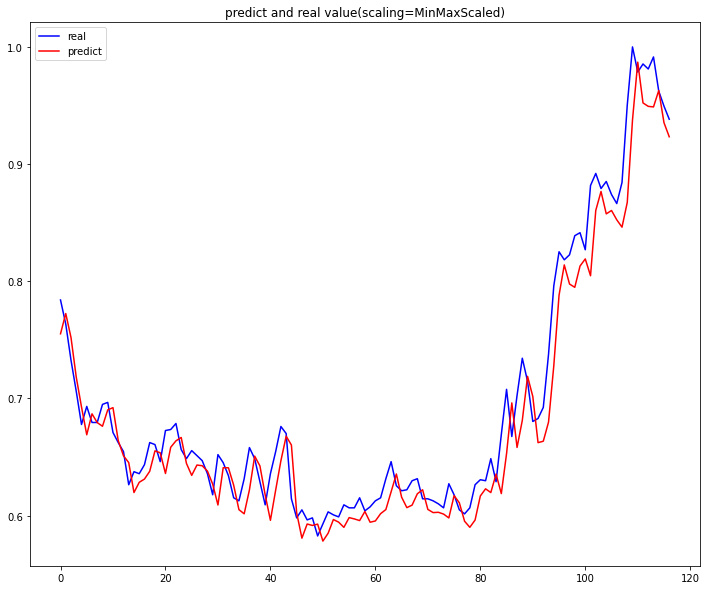

In [51]:
fig,ax=plt.subplots(1,1 ,figsize=(12,10))
ax.plot(y_test1,color='b')
ax.plot(pred,color='r')
ax.set_title("predict and real value(scaling=MinMaxScaled)")
ax.legend(['real','predict'],loc='upper left')
plt.show()